## Callbacks

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

It is sometimes convenient to be able to implement custom code at certain points in the training process. A "callback" is one way of doing this. Essentially, a callback is an object that has certain methods implemented. When the object is passed in to the `fit` method of a pomegranate object, these methods will be automatically called at predetermined points during training. These methods an implement a wide variety of functionality, but a few common callbacks include model checkpointing, where the model is written out to disk after each epoch, early stopping, where the training of a model stops early based on performance on a validation set, and even TensorBoard, which displays the results of training of multiple models.

Callbacks are implemented in pomegranate using a similar approach to that of keras. The base callback looks like the following: 

```python
class Callback(object):
	"""An object that adds functionality during training.

	A callback is a function or group of functions that can be executed during
	the training process for any of pomegranate's models that have iterative
	training procedures. A callback can be called at three stages-- the
	beginning of training, at the end of each epoch (or iteration), and at
	the end of training. Users can define any functions that they wish in
	the corresponding functions.
	"""

	def __init__(self):
		self.model = None
		self.params = None

	def on_training_begin(self):
		"""Functionality to add to the beginning of training.

		This method will be called at the beginning of each model's training
		procedure.
		"""

		pass

	def on_training_end(self, logs):
		"""Functionality to add to the end of training.

		This method will be called at the end of each model's training
		procedure.
		"""

		pass

	def on_epoch_end(self, logs):
		"""Functionality to add to the end of each epoch.

		This method will be called at the end of each epoch during the model's
		iterative training procedure.
		"""

		pass
```

During the training process the `self.model` attribute gets set to the model that is being trained, allowing users to interact with it and use the methods. 

A user can define a custom callback by simply by inheriting from this object (in pomegranate.callbacks) and implementing the methods that they care about. This doesn't have to be all of the methods.

There are a few callbacks that are built-in to pomegranate:
1. ModelCheckpoint: This callback will save a copy of the model every few epochs in case the user is performing a long-running job.
2. History: This callback will save the logs generated during training and return them in a convenient object.
3. CSVLogger: This callback is similar to History except that it will save the logs to a given CSV file
4. LambdaCallback: This callback allows one to pass in function objects for each of the three methods to execute rather than define ones own custom callback.

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

from pomegranate import *

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Sun Dec 01 2019 

numpy 1.17.2
scipy 1.3.1
pomegranate 0.11.3

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-66-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


### Using a callback

Let's first take a look at how to use the built-in callbacks. We'll start off with the History callback, which is already automatically created and updated during training. You can return the history object with the data stored in it using the `return_history` parameter during training.

In [2]:
X = numpy.random.randn(10000, 13)

d1 = MultivariateGaussianDistribution(numpy.zeros(13), numpy.eye(13))
d2 = MultivariateGaussianDistribution(numpy.ones(13), numpy.eye(13))

model = GeneralMixtureModel([d1, d2])
_, history = model.fit(X, return_history=True)

After training we can use the history object to make several useful plots. An intuitive plot is the log probability of the data set given the model $P(D|M)$ over the number of epochs of training.

Text(0, 0.5, 'Log Probability')

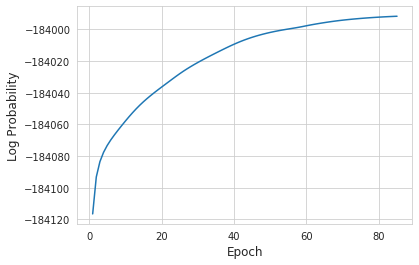

In [3]:
plt.plot(history.epochs, history.log_probabilities)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Log Probability", fontsize=12)

As we expected, the log probability of the data set goes up during training, because the model is being explicitly fit to the data set.

Now let's look at how to pass in additional callbacks. Let's take a look at the CSV logger. All we have to do is create the CSVLogger object by passing in the name of the file to save to and then pass that object in to the fit function.

In [4]:
import pandas
from pomegranate.callbacks import CSVLogger

d1 = MultivariateGaussianDistribution(numpy.zeros(13), numpy.eye(13))
d2 = MultivariateGaussianDistribution(numpy.ones(13), numpy.eye(13))

model = GeneralMixtureModel([d1, d2])
model.fit(X, callbacks=[CSVLogger("logs.csv")])

logs = pandas.read_csv("logs.csv")
logs.head()

,epoch,duration,total_improvement,improvement,log_probability,last_log_probability,epoch_start_time,epoch_end_time,n_seen_batches,learning_rate
0,1,0.002165,6079.062778,6079.062778,-184116.511097,-190195.573874,1.575228e+09,1.575228e+09,None,0.0
1,2,0.002047,6102.391290,23.328513,-184093.182584,-184116.511097,1.575228e+09,1.575228e+09,None,0.0
2,3,0.002156,6112.050803,9.659512,-184083.523072,-184093.182584,1.575228e+09,1.575228e+09,None,0.0
3,4,0.002037,6117.923677,5.872874,-184077.650198,-184083.523072,1.575228e+09,1.575228e+09,None,0.0
4,5,0.002295,6122.236641,4.312964,-184073.337234,-184077.650198,1.575228e+09,1.575228e+09,None,0.0


The CSV will now contain the information that the History object stores, but in a convenient written format. Note that some of the columns will correspond to information that isn't particularly useful for normal training, such as "learning rate." While conceptually similar to the learning rate used in training neural networks, EM does not necessarily benefit in the same way that gradient descent does from tuning it.

### Implementing a custom callback

Now let's look at an example of creating a custom callback. This callback will take in a training and a validation set and output both the training and validation set log probabilities. Currently, pomegranate does not allow for a user to pass a validation set in to the fit function and monitor performance that way, so this custom callback is an easy way around that limitation.

In [5]:
from pomegranate.callbacks import Callback

class ValidationSetCallback(Callback):
    """This callback evaluates a validation set after each epoch."""

    def __init__(self, X_train, X_valid):
        self.X_train = X_train
        self.X_valid = X_valid
        self.model = None
        self.params = None

    def on_epoch_end(self, logs):
        """Functionality to add to the end of each epoch.

        This method will be called at the end of each epoch during the model's
        iterative training procedure.
        """
    
        epoch = logs['epoch']
        train_logp = self.model.log_probability(self.X_train).sum()
        valid_logp = self.model.log_probability(self.X_valid).sum()
        
        print("Epoch {} -- Training LogP: {:4.4} -- Validation LogP: {:4.4}".format(epoch, train_logp, valid_logp))

The above code seems fairly simple. All we do is store the data sets that are passed in and then calculate their respective log probabilities at the end of each epoch and print that out to the screen. Let's see how it works on a data set.

In [6]:
numpy.random.seed(0)

X_train = numpy.concatenate([
    numpy.random.normal(0, 1.0, size=(500, 5)),
    numpy.random.normal(0.3, 0.8, size=(500, 5)),
    numpy.random.normal(-0.3, 0.4, size=(500, 5))
])

idx = numpy.arange(X_train.shape[0])
numpy.random.shuffle(idx)
X_train = X_train[idx]

X_valid = X_train[:500]
X_train = X_train[500:]


callback = ValidationSetCallback(X_train, X_valid)

d1 = MultivariateGaussianDistribution(numpy.zeros(5), numpy.eye(5))
d2 = MultivariateGaussianDistribution(numpy.ones(5), numpy.eye(5))
d3 = MultivariateGaussianDistribution(-numpy.ones(5), numpy.eye(5))

model = GeneralMixtureModel([d1, d2, d3])
_ = model.fit(X_train, callbacks=[callback])

Epoch 1 -- Training LogP: -5.874e+03 -- Validation LogP: -2.949e+03
Epoch 2 -- Training LogP: -5.825e+03 -- Validation LogP: -2.93e+03
Epoch 3 -- Training LogP: -5.747e+03 -- Validation LogP: -2.895e+03
Epoch 4 -- Training LogP: -5.675e+03 -- Validation LogP: -2.859e+03
Epoch 5 -- Training LogP: -5.647e+03 -- Validation LogP: -2.845e+03
Epoch 6 -- Training LogP: -5.64e+03 -- Validation LogP: -2.842e+03
Epoch 7 -- Training LogP: -5.637e+03 -- Validation LogP: -2.842e+03
Epoch 8 -- Training LogP: -5.635e+03 -- Validation LogP: -2.842e+03
Epoch 9 -- Training LogP: -5.634e+03 -- Validation LogP: -2.843e+03
Epoch 10 -- Training LogP: -5.633e+03 -- Validation LogP: -2.843e+03
Epoch 11 -- Training LogP: -5.632e+03 -- Validation LogP: -2.844e+03
Epoch 12 -- Training LogP: -5.632e+03 -- Validation LogP: -2.844e+03
Epoch 13 -- Training LogP: -5.631e+03 -- Validation LogP: -2.844e+03
Epoch 14 -- Training LogP: -5.631e+03 -- Validation LogP: -2.844e+03
Epoch 15 -- Training LogP: -5.631e+03 -- Vali

Simple! All we did was create the object and then pass it in to the callbacks parameter during fitting. We can see that the validation log probability initially goes down with the training set log probability, but then goes up a little bit, showing that the model is beginning to overfit a tiny bit to the data set.